In [1]:
import cv2,os
import time
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from skimage import io, transform
from skimage.io import imread, imshow

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cpu)


# debug

In [4]:
# path = data_dir
# folders = os.listdir(path)
# idx = 0

# image_folder = os.path.join(path,folders[idx],'images/')
# mask_folder = os.path.join(path,folders[idx],'masks/')
# image_path = os.path.join(image_folder,os.listdir(image_folder)[0])

        
# mk = np.zeros((256, 256, 1),dtype=bool)  
# for mask in os.listdir(mask_folder):
#     mask = io.imread(os.path.join(mask_folder,mask))
#     mask = np.expand_dims(mask,axis=-1)
#     mk = np.maximum(mk, mask)

    
    
# hist = cv2.calcHist([mk],[0],None,[256],[0,256])

# print(mk.shape)
# # print(hist)
# plt.imshow(mk)

# data for train

In [5]:
batch_size=1
image_size=512

data_dir = "../../Datasets/data-science-bowl-2018/stage1_train/"

In [6]:
get_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(image_size),
])

In [7]:
class CustomDataset(Dataset):
    def __init__(self,path):
        self.path = path
        self.folders = os.listdir(path)

    def __getitem__(self,idx):
        image_folder = os.path.join(self.path,self.folders[idx],'images/')
        mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
        image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
    
        img = io.imread(image_path)[:,:,:3]
        img = transform.resize(img, (image_size,image_size))
        masks, boxes = self.get_mask_boxes(mask_folder, image_size)

        image = get_transform(img)
        boxes = torch.tensor(boxes, dtype=torch.double)
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        masks = get_transform(masks)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }
        return (image,target) 

    def get_mask_boxes(self, mask_folder, img_size):
        mask = np.zeros((img_size, img_size, 1),dtype=bool)
        boxes = []
        for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder,mask_))
            mask_ = transform.resize(mask_, (img_size, img_size))
            mask_ = np.expand_dims(mask_,axis=-1)
            
            pos = np.where(mask_)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            
            mask = np.maximum(mask, mask_)
        return mask, boxes
        
    def __len__(self):
        return len(self.folders)

len(datas):  11
image.shape:  torch.Size([3, 512, 512])
mask.shape:  torch.Size([1, 512, 512])
boxes.shape:  torch.Size([13, 4])


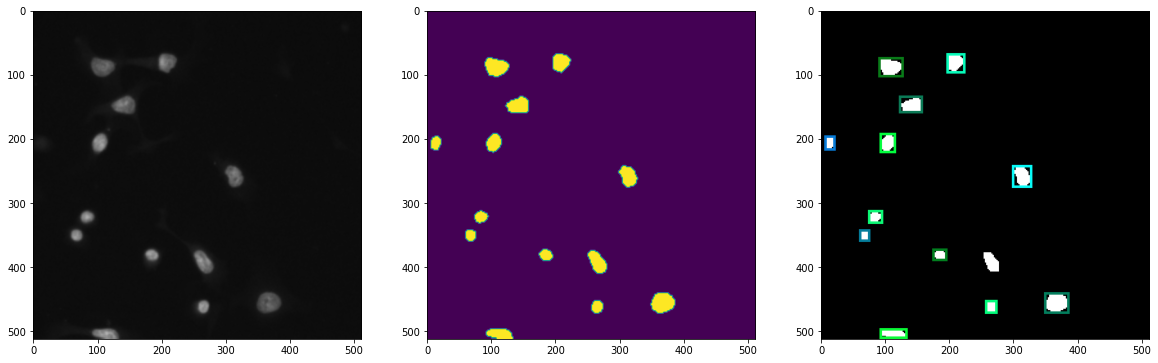

In [14]:
datas = CustomDataset(data_dir)
print("len(datas): ",len(datas))

image, target = datas[1]
print("image.shape: ",image.shape)
# print(torch.amax(image).item(),torch.amin(image).item())
print("mask.shape: ",target["masks"].shape)
# print(torch.amax(mask).item(),torch.amin(mask).item())
print("boxes.shape: ",target["boxes"].shape)
with_boxes = draw_bounding_boxes(target["masks"].to(torch.uint8)*255, target["boxes"], width=4)


plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.imshow(image.permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(target["masks"].permute(1,2,0))
plt.subplot(1,3,3)
plt.imshow(with_boxes.permute(1,2,0))

1 10
1 10
torch.Size([1, 3, 512, 512]) torch.Size([1, 1, 512, 512])


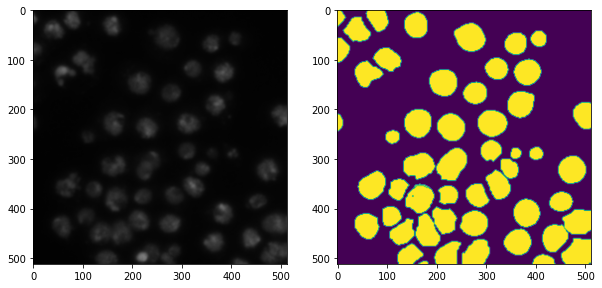

In [15]:
train_len = int(0.1*len(datas))
val_len = len(datas)-train_len
train_data, val_data = torch.utils.data.random_split(datas, [train_len, val_len])

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

print(len(train_data), len(val_data))
print(len(train_loader), len(val_loader))

val_imgs, val_targets = iter(val_loader).next()
val_masks = val_targets["masks"]
print(val_imgs.shape, val_masks.shape)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(val_imgs[0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(val_masks[0].permute(1,2,0))

# model for train

In [10]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [16]:
def get_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes+1) 
    return model

model = get_model(2)
model.double()
model.to(device)

for param in model.parameters():
    param.requires_grad = True
    
model.train()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [17]:
epochs = 5
learning_rate = 3e-4
momentum = 0.9
weight_decay = 0.0005

USE_SCHEDULER = False
PCT_IMAGES_VALIDATION = 0.075

print(len(train_loader), len(val_loader))

1 10


In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
# optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

n_batches, n_batches_val = len(train_loader), len(val_loader)

validation_mask_losses = []

for epoch in range(1, epochs + 1):
    print(f"Starting epoch {epoch} of {epochs}")

    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0
    loss_classifier_accum = 0.0
    for batch_idx, (images, targets) in enumerate(train_loader, 1):
    
        # Predict
        images = list(image.to(device) for image in images)
        targets = [{k: targets.get(k)[t].to(device) for k in targets} for t in range(targets["boxes"].shape[0])]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask
        loss_classifier_accum += loss_dict['loss_classifier'].item()
        
        if batch_idx % 500 == 0:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}.")
                        
    if USE_SCHEDULER:
        lr_scheduler.step()

    # Train losses
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches
    train_loss_classifier = loss_classifier_accum / n_batches

    # Validation
    val_loss_accum = 0
    val_loss_mask_accum = 0
    val_loss_classifier_accum = 0
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(val_loader, 1):
            images = list(image.to(device) for image in images)
            targets = [{k: targets.get(k)[t].to(device) for k in targets} for t in range(targets["boxes"].shape[0])]

            val_loss_dict = model(images, targets)
            val_batch_loss = sum(loss for loss in val_loss_dict.values())
            val_loss_accum += val_batch_loss.item()
            val_loss_mask_accum += val_loss_dict['loss_mask'].item()
            val_loss_classifier_accum += val_loss_dict['loss_classifier'].item()

    # Validation losses
    val_loss = val_loss_accum / n_batches_val
    val_loss_mask = val_loss_mask_accum / n_batches_val
    val_loss_classifier = val_loss_classifier_accum / n_batches_val
    elapsed = time.time() - time_start

    validation_mask_losses.append(val_loss_mask)
#     torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
    prefix = f"[Epoch {epoch:2d} / {epochs:2d}]"
    print(prefix)
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}, classifier loss {train_loss_classifier:7.3f}")
    print(f"{prefix} Val mask-only loss  : {val_loss_mask:7.3f}, classifier loss {val_loss_classifier:7.3f}")
    print(prefix)
    print(f"{prefix} Train loss: {train_loss:7.3f}. Val loss: {val_loss:7.3f} [{elapsed:.0f} secs]")
    print(prefix)

Starting epoch 1 of 5


# eval of model

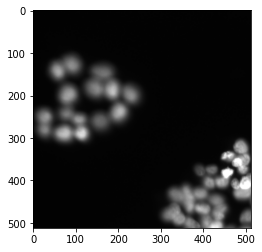

In [8]:
path = "../../Datasets/211202NDA/NDAcquisition-01_XY256.ome.tif"

img = cv2.imread(path)
img = img[100:612,100:612,:]
# img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# img = cv2.resize(img,(512,512))
plt.imshow(img)

In [25]:
# weights_path = '../../Datasets/weights/mask_rcnn_kaggle_v1.h5'
# weights = torch.load(weights_path)

model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
# model.load_state_dict(torch.load(weights_path))

In [11]:
model.eval()
output = model(transform(img).unsqueeze(0))[0]

print(output["boxes"].shape)
print(output["labels"].shape)
print(output["scores"].shape)
print(output["masks"].shape)

print(output["labels"])
print(output["scores"])

torch.Size([3, 4])
torch.Size([3])
torch.Size([3])
torch.Size([3, 1, 512, 512])
tensor([3, 3, 4])
tensor([0.2665, 0.0968, 0.0851], grad_fn=<IndexBackward0>)


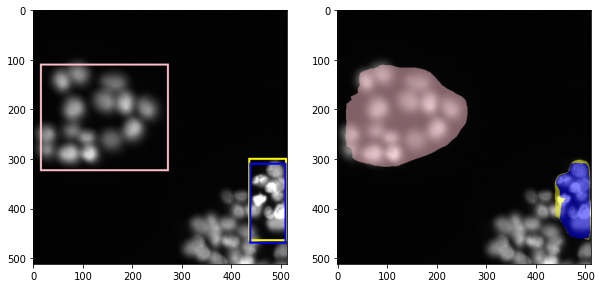

In [23]:
score_threshold = 0.0
backimg = torch.tensor(np.transpose(img,(2,0,1)))
colors = ["yellow","pink","blue"]

boxes = output['boxes'][output['scores'] > score_threshold]
with_boxes = draw_bounding_boxes(backimg, boxes, colors=colors, width=4)

masks = output['masks'][output['scores'] > score_threshold][:,0,:,:].ge(0.5)
with_masks = draw_segmentation_masks(backimg, masks, alpha=0.5, colors=colors)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.transpose(with_boxes,(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(with_masks,(1,2,0)))

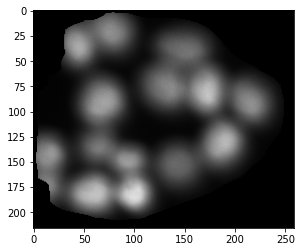

In [38]:
backimg = torch.tensor(np.transpose(img,(2,0,1)))
n = 1
im = backimg.masked_fill_(masks[n]==False, 0)
im = np.transpose(im,(1,2,0))
x1,x2,y1,y2 = int(boxes[n,1].item()),int(boxes[n,3].item()),int(boxes[n,0].item()),int(boxes[n,2].item())
im = im[x1:x2,y1:y2,:]

plt.imshow(im)